In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import pickle

**Show Schematic of the Convolutional Neural Network**

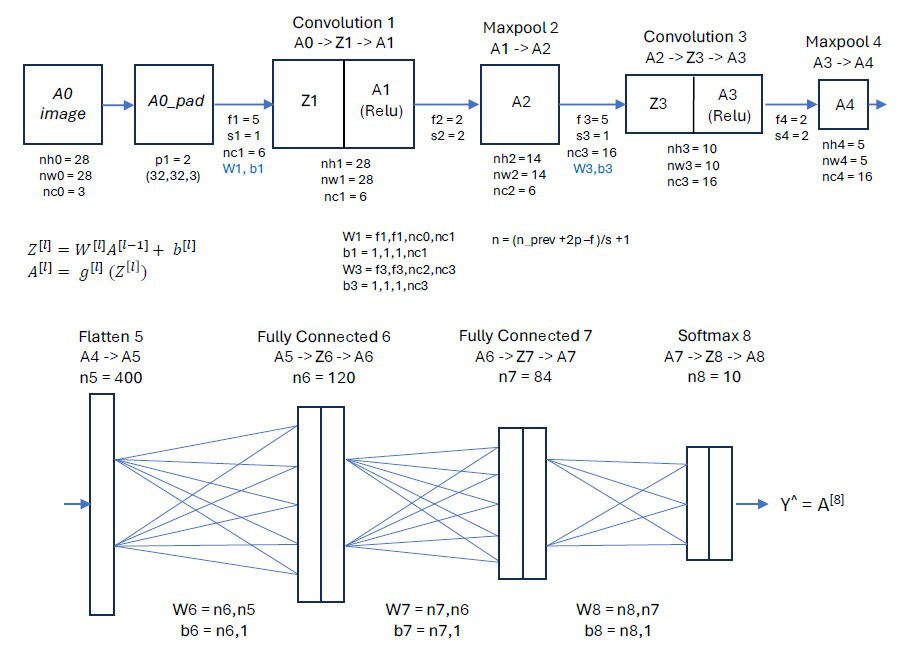

In [3]:
from PIL import Image
from IPython.display import display

img = Image.open('Images/CNN_schematic.jpg')
display(img)

**Import Training Data**

In [2]:
"""
Import Training Data from CIFAR-10 dataset

CIFAR-10 contains 5 training files with 10,000 images each
CIFAR-10 shape is (10000, 32X32x3) = (10000, 3072)
CIFAR-10 contains 1 test file with 10,000 images
Each CIFAR-10 file also has a corresponding list for label categories (0-9), length = 10000


A0_CIFAR = input images = (m_train,n_h,n_w,nc)
Y_CIFAR = labels for softmax = (10,m_train)
train_labels_all = simple label list (m_train)

m_train = total number of samples

"""

# unpickle function from CIFAR homepage
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

db1=unpickle('CIFAR/data_batch_1')   # db1 is a dictionary
db2=unpickle('CIFAR/data_batch_2')   # db2 is a dictionary
db3=unpickle('CIFAR/data_batch_3')   # db3 is a dictionary
db4=unpickle('CIFAR/data_batch_4')   # db4 is a dictionary
db5=unpickle('CIFAR/data_batch_5')   # db5 is a dictionary

# dictionary labels
key_list=list(db1.keys())

# extract labels and data from dictionary
tl1 = db1[b'labels']       # list
td1 = db1[b'data']         # numpy array. unsigned int 8 bit, uint8. 10000 x 3072

tl2 = db2[b'labels'] 
td2 = db2[b'data']  

tl3 = db3[b'labels'] 
td3 = db3[b'data']

tl4 = db4[b'labels'] 
td4 = db4[b'data']

tl5 = db5[b'labels'] 
td5 = db5[b'data']

# concacenate training data
train_data_all = np.concatenate((td1,td2,td3,td4,td5),axis=0)
train_labels_all = tl1 + tl2 + tl3 + tl4 + tl5 

# just use db1 with 10000 samples for testing code
#train_data_all = td1
#train_labels_all = tl1

# size of labels and data
print("train_labels_all length",len(train_labels_all))
print("train_data_all shape",train_data_all.shape)

# total number of samples
m_train = train_data_all.shape[0]
print('no of training samples =',m_train)

A0_temp = np.array(train_data_all[:,:]/255).reshape(m_train,3,32,32)
A0_CIFAR = A0_temp.transpose(0,2,3,1)

# create target matrix y = [10, m_train]
Y_CIFAR = np.zeros([10,m_train])

# convert target integer into an array
for i in range(m_train):
    Y_CIFAR[int(train_labels_all[i]),i] = 1

print("A0_CIFAR shape =", A0_CIFAR.shape)
print("Y_CIFAR shape =", Y_CIFAR.shape)

label_names = ['airoplane','auto','bird','cat','deer','dog','frog','horse','ship','truck']


train_labels_all length 50000
train_data_all shape (50000, 3072)
no of training samples = 50000
A0_CIFAR shape = (50000, 32, 32, 3)
Y_CIFAR shape = (10, 50000)


In [ ]:
# plot a single CIFAR-10 training image

im_no=2005

print("label",im_no," =",label_names[train_labels_all[im_no]])

im = A0_CIFAR[im_no,:,:,:]
plt.imshow(im)
plt.show()

#im=mpimg.imread('CIFAR/john_pic.jpg')  this is to convert a jpg to np array and plot


**Import Test Data**

In [3]:
"""
Import Test Data from CIFAR-10 dataset

A0_test = input images = (m_test,n_h,n_w,nc)
Y_test = labels for softmax = (10,m_test)

m_test = total number of test samples

"""

# unpickle function from CIFAR homepage
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

tb=unpickle('CIFAR/test_batch')   # tb is a dictionary

# dictionary labels
key_list=list(tb.keys())

# extract labels and data from dictionary
test_labels=tb[b'labels']       # python list
test_data=tb[b'data']           # numpy array, unsigned int 8 bit, uint8. 10000 x 3072

# size of labels and data
print("test_labels",len(test_labels))
print("test_data",test_data.shape)

# total number of samples
m_test = test_data.shape[0]
print('no of test samples =',m_test)

A0_temp = np.array(test_data[:,:]/255).reshape(m_test,3,32,32)
A0_test = A0_temp.transpose(0,2,3,1)

# create target matrix y = [10, m]
Y_test = np.zeros([10,m_test])

# target is first number in each row
for i in range(m_test):
    Y_test[int(test_labels[i]),i] = 1

print("A0_test shape =", A0_test.shape)
print("Y_test shape =", Y_test.shape)

label_names = ['airoplane','auto','bird','cat','deer','dog','frog','horse','ship','truck']


test_labels 10000
test_data (10000, 3072)
no of test samples = 10000
A0_test shape = (10000, 32, 32, 3)
Y_test shape = (10, 10000)


In [ ]:
# plot a single CIFAR-10 test image

im_no=998

print("label",im_no," =",label_names[test_labels[im_no]])

im = A0_test[im_no,:,:,:]
plt.imshow(im)
plt.show()

**Function Definitions**

In [4]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image
    
    Argument:
    X = numpy array (m, n_H, n_W, n_C) representing a batch of m images
    pad = integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad = padded image of shape (m, n_H + 2 * pad, n_W + 2 * pad, n_C)
    """
    
    X_pad = np.pad(X, ((0,0),(pad,pad),(pad,pad),(0,0)), mode='constant', constant_values = (0,0))

    return X_pad


In [5]:
def conv_forward(A_prev, W, b, stride):
    
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev = output activations of the previous layer (m, n_H_prev, n_W_prev, n_C_prev)
    W = Weights (f, f, n_C_prev, n_C)
    b = Biases (1, 1, 1, n_C)
    stride = scalar
        
    Returns:
    Z = convolution output (m, n_H, n_W, n_C)
    """

    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Compute the dimensions of the CONV output volume 
    n_H = int(1 + (n_H_prev - f)/stride)
    n_W = int(1 + (n_W_prev - f)/stride)
    
    # Initialize the output volume Z with zeros.
    Z = np.zeros((m,n_H,n_W,n_C))
    
    for i in range(m):                      # loop over the mini-batch of training examples
        a_prev = A_prev[i]                  # Select ith training example's activation
        
        for h in range(n_H):                # loop over vertical axis of the output volume
            
            # Find the vertical start and end of the current slice of a_prev 
            vert_start = h * stride
            vert_end = vert_start + f
            
            for w in range(n_W):            # loop over horizontal axis of the output volume
                
                # Find the horizontal start and end of the current slice of a_prev 
                horiz_start = w * stride
                horiz_end = horiz_start + f
                
                for c in range(n_C):   # loop over filters = channels of the output volume
                                        
                    # Use the corners to define the (3D) slice of a_prev, including all input channels
                    a_slice_prev = a_prev[vert_start:vert_end,horiz_start:horiz_end,:]  # f x f x n_C_prev
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output cell
                    weights = W[:,:,:,c]   # weights of filter c - same shape as a_slice_prev
                    bias = b[:,:,:,c]      # bias of filter c - single value
                    s = a_slice_prev * weights    # s is shape (f,f,nc_prev)
                    Zs = np.sum(s)
                    Zs = Zs + np.float64(bias)  # Zs is a scalar
                    Z[i, h, w, c] = Zs
    
    return Z


In [6]:
def maxpool_forward(A_prev,f,stride):
    
    """
    Implements the forward pass of the maxpooling layer
    
    Arguments:
    A_prev = Input data (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    A = output of the pool layer (m, n_H, n_W, n_C_prev)
     
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Compute the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):                           # loop over the training examples
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            # Find the vertical start and end of the current slice
            vert_start = h * stride
            vert_end = vert_start + f
            
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                # Find the vertical start and end of the current slice
                horiz_start = w * stride
                horiz_end = horiz_start + f
                
                for c in range (n_C):            # loop over the channels
                    
                    # Use the corners to define the current slice on the ith training example of A_prev
                    a_prev_slice = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]  # f x f array
                    
                    # Compute the pooling operation on the slice
                    A[i, h, w, c] = np.max(a_prev_slice)
                   
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A


In [7]:
"""
Convolutional Neural Network - Define Functions

"""

# define Relu activation forward function
def relu(x):
    return np.maximum(0,x)

# define Relu backward
def relu_back(da,z):     # dL/dz = dL/da x da/dz
    dz = np.copy(da)     #       = dl/da x 1 if z>0
    dz[z <= 0] = 0       #       = dL/da x 0 if z<=0
    return dz


# define softmax forward function
def softmax(x):
    t=np.exp(x)
    t_sum=np.sum(t,axis=0)   # sum vertical, across columns
    a=t/t_sum                # broadcasting
    return a

# define softmax cost
def softmax_cost(a,y,m):     # a=output, y=label, m=mini-batch samples
    x = -y * np.log(a)
    sum = (1/m)*np.sum(x)    # sums over rows and columns
    return(sum)


In [8]:
def maxpool_back(dA, A_prev, f, stride):
    
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA = grads of the pooling layer, same shape as A
    A_prev = needed to define shape of dA_prev
    f = filter size
    stride = stride size
    
    Returns:
    dA_prev -- grads of the input of the pooling layer, same shape as A_prev
    """
    
    # Retrieve dimensions from A_prev's shape and dA's shape
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros
    dA_prev = np.zeros((m,n_H_prev,n_W_prev,n_C_prev))
    
    for i in range(m): # loop over the training examples
        
        # select training example from A_prev
        a_prev = A_prev[i,:,:,:]
        
        for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
        
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h*stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Compute the backward propagation
                    
                    # Use the corners and "c" to define the current slice from a_prev
                    a_prev_slice = a_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                        
                    # Create the mask from a_prev_slice
                    xx = a_prev_slice   # array of shape fxf
                    mask = (xx == (np.max(xx)))
                    
                    # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA)
                    dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += mask * dA[i,h,w,c]
                        
    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev


In [9]:
def conv_back(dZ, A_prev, W, stride):
    
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ = grads (m, n_H, n_W, n_C)
    A_prev = previous activation (m, n_H_prev, n_W_prev, n_C_prev) -- if padded, this will be A_prev_pad
    W = weights (f,f,n_C_prev,n_C)
    stride = stride (scalar)
    
    Returns:
    dA_prev = grads for previous activation (m, n_H_prev, n_W_prev, n_C_prev)
    dW = grads for weights (f, f, n_C_prev, n_C)
    db = grads for biases (1, 1, 1, n_C)
    """    
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    
    for i in range(m):                       # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev = A_prev[i,:,:,:]
        da_prev = dA_prev[i,:,:,:]
        
        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume - filter number
                    
                    # Find the corners of the current slice
                    vert_start = h*stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f

                    # Use the corners to define the slice (3d) from a_prev_pad
                    a_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # Update gradients for the slice (f,f,n_C_prev). W[:,:,:,c] has shape (f,f,n_C). dZ is a scalar
                    # this is basically back propogating dZ by filter weights.
                    # each of the output channels (n_c) contributes to all the input channels (n_C_prev).
                    da_prev[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # Set the ith training example's dA_prev to the unpadded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        
        dA_prev[i, :, :, :] = da_prev[:,:,:]
        
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    dW=(1/m)*dW   # average grads over all mini-batches
    db=(1/m)*db   # average grads over all mini-batches
    
    return dA_prev, dW, db


In [10]:
def unpad(dA_pad,A_prev,pad):
    
    (m, n_H, n_W, n_C) = dA_pad.shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    
    dA_prev[:, :, :, :] = dA_pad[:,pad:-pad,pad:-pad,:] 

    return dA_prev


**Set Parameters and Hyperparameters**

In [11]:
"""
Set Model Hyperparameters and Parameters

5-layer neural network
CONV-ReLU-Maxpool x CONV-ReLU-Maxpool x Flatten x FC-ReLU x FC-ReLU x FC-Softmax

A0_train = All training input data (m_train,nh,nw,nc)
Y_train = All labels for Softmax (10,m_train)
"""

# 5 layer network. CONV x CONV x FC x FC x Softmax
# Define Hyperparameters - Filters, Padding and Strides

# input layer A[0]
nc0 = 3           # number of channels in A0 = RGB

# Convolutional A[1]
f1 = 5            # filter size
s1 = 1            # stride 
p1 = 2            # padding 
nc1 = 6           # no filters = number of channels in A1

# Maxpool A[2]
f2 = 2          # filter size
s2 = 2          # stride 
nc2 = nc1

# Convolutional A[3]
f3 = 5            # filter size
s3 = 1            # stride
nc3 = 16          # no filters = number of channels in A3

# Maxpool A[4]
f4 = 2            # filter size
s4 = 2            # stride
nc4 = nc3

# Define nodes for Fully Connected layers
n5 = 400  # flattened layer from maxpool
n6 = 120  # FC layer
n7 = 84   # FC layer
n8 = 10   # softmax 0-9 layer

# initialise parameters - weights and biases for two convolutional layers
W1 = np.random.randn(f1, f1, nc0, nc1) * 0.1
b1 = np.zeros((1, 1, 1, nc1))

W3 = np.random.randn(f3, f3, nc2, nc3) * 0.1
b3 = np.zeros((1, 1, 1, nc3))

# initialise parameters - weights and biases for three fully connected layers
W6 = np.random.randn(n6, n5) * 0.1
b6 = np.zeros((n6, 1))
W7 = np.random.randn(n7, n6) * 0.1
b7 = np.zeros((n7, 1))        
W8 = np.random.randn(n8, n7) * 0.1
b8 = np.zeros((n8, 1))

# cost function list
cost = []   # put this here so it an be added-to when re-running main program

epoch_count=0


**Main Program**

In [ ]:
"""
Train Convolutional Neural Network - forward and back prop
Mini-Batch Gradient descent

A0_batch = All training input data [mt,nh,nw,nc]
Y_batch = All labels for Softmax (10,mt)

5-layer neural network
CONV-ReLU-Maxpool x CONV-ReLU-Maxpool x Flatten x FC-ReLU x FC-ReLU x FC-Softmax

parameters; W1,b1,W3,b3,W6,b6,W7,b7,W8,b8

hyperparameters;
learning rate = learn
no of epochs = epochs
mini batch size = m_mb
no of mini-batches = t

"""

start = time.time()
print("start time =", time.ctime(start))

A0_Batch=A0_CIFAR
Y_Batch=Y_CIFAR

print("shape A0_Batch =", A0_Batch.shape)
print("shape Y_Batch =", Y_Batch.shape)

m_train=A0_Batch.shape[0]
print("total number of samples in whole batch =", m_train)

# initialise hyperparameters
epochs = 1
m_mb = 64                        # number of samples per mini-batch
t = int(m_train/m_mb)            # number of mini batches
learn = 0.01                     # learning rate

print("no. of epochs =",epochs)
print("no. of samples per mini-batch =", m_mb)
print("total no. of mini-batches =",t)
print("learning rate =",learn)

for ep in range(epochs):
    epoch_count +=1
    print("\nepoch = ",ep+1, " epoch_count =", epoch_count)
    for k in range(t):
        # print("mini batch = ",k+1)
    
        # select correct samples for the mini batch
        A0 = A0_Batch[k*m_mb:(k+1)*m_mb,:,:,:]    # images
        Y = Y_Batch[:,k*m_mb:(k+1)*m_mb]          # labels
        
        ###############################################
        ### Forward Prop
        ###############################################
        
        # Pad A0 -> A0_pad 
        # A0_pad = zero_pad(A0,p1)
        
        # CONV A0_pad -> Z1
        # Z1 = conv_forward(A0_pad, W1, b1, s1)
        Z1 = conv_forward(A0, W1, b1, s1)
        
        # Relu1 Z1 -> A1
        A1 = relu(Z1)
        
        # Maxpool A1 -> A2
        A2 = maxpool_forward(A1,f2,s2)
        
        # CONV A2 -> Z3
        Z3 = conv_forward(A2, W3, b3, s3)
        
        # Relu Z3 -> A3
        A3 = relu(Z3)
        
        # Maxpool A3 -> A4
        A4 = maxpool_forward(A3,f4,s4)
        
        # Flatten A4 -> A5
        A5=A4.reshape(m_mb,-1).T  
        
        # FC relu layer A5 -> Z6 -> A6
        Z6 = np.dot(W6,A5) + b6
        A6 = relu(Z6)

        # FC relu layer A6 -> Z7 -> A7
        Z7 = np.dot(W7,A6) + b7
        A7 = relu(Z7)
    
        # FC softmax layer A7 -> Z8 -> A8
        Z8 = np.dot(W8,A7) + b8
        A8 = softmax(Z8)
        
        # Calculate Cost function for each mini batch
        rcost = softmax_cost(A8,Y,m_mb)  # latest cost
        cost.append(rcost)
        
        # Print Latest Cost after mini batch
        print("mini-batch ",k+1, ", cost ",rcost)

        ###############################################
        ### Back Prop
        ###############################################
        
        # Backprop FC softmax A8
        dZ8 = A8 - Y
        dW8 = (1/m_mb)*np.dot(dZ8,A7.T)
        db8 = (1/m_mb)*np.sum(dZ8,axis=1,keepdims=True)
        dA7 = np.dot(W8.T,dZ8)

        # Backprop FC relu A7
        dZ7 = relu_back(dA7,Z7)
        dW7 = (1/m_mb)*np.dot(dZ7,A6.T)
        db7 = (1/m_mb)*np.sum(dZ7,axis=1,keepdims=True)
        dA6 = np.dot(W7.T,dZ7)
        
        # Backprop FC relu A6
        dZ6 = relu_back(dA6,Z6)
        dW6 = (1/m_mb)*np.dot(dZ6,A5.T)
        db6 = (1/m_mb)*np.sum(dZ6,axis=1,keepdims=True)
        dA5 = np.dot(W6.T,dZ6)

        # Un-flatten dA5 -> dA4
        nh4=A4.shape[1]
        nw4=A4.shape[2]
        dA4=(dA5.T).reshape(m_mb,nh4,nw4,nc4)
        
        # Backward Maxpool dA4 -> dA3
        dA3 = maxpool_back(dA4,A3,f4,s4)
         
        # Backward Relu dA3 -> dZ3
        dZ3 = relu_back(dA3,Z3)
        
        # Backward CONV dZ3 -> dA2
        dA2,dW3,db3 = conv_back(dZ3,A2,W3,s3)

        # Backward Maxpool dA2 -> dA1
        dA1 = maxpool_back(dA2,A1,f2,s2)

        # Backward Relu dA1 -> dZ1
        dZ1 = relu_back(dA1,Z1)
        
        # Backward CONV dZ1 -> dA0_pad (or dA0 if no padding used)
        # dA0_pad,dW1,db1 = conv_back(dZ1,A0_pad,W1,s1)
        dA0,dW1,db1 = conv_back(dZ1,A0,W1,s1)
        
        # Unpad dA_0 -> dA0  (not necessary but for completeness)
        # dA0 = unpad(dA0_pad,A0,p1)
        
        # update parameters
        W1 = W1 - learn*dW1
        b1 = b1 - learn*db1
        W3 = W3 - learn*dW3
        b3 = b3 - learn*db3
        W6 = W6 - learn*dW6
        b6 = b6 - learn*db6
        W7 = W7 - learn*dW7
        b7 = b7 - learn*db7
        W8 = W8 - learn*dW8
        b8 = b8 - learn*db8
        
end = time.time()
print('\n\nfinal run time=',(end-start)/60," minutes")


In [ ]:
# plot cost

plt.plot(cost,color="r")
plt.show()

**Testing and Performance**

In [ ]:
"""
Test Convolutional Neural Network
"""

start = time.time()
print("start time =", time.ctime(start))

m_test = A0_test.shape[0]
print("number of samples in test batch =", m_test)

A0 = A0_test        # images
Y = Y_test          # labels in softmax format

# Pad A0 -> A0_pad 
# A0_pad = zero_pad(A0,p1)
        
# CONV A0_pad -> Z1
Z1 = conv_forward(A0, W1, b1, s1)

# Relu1 Z1 -> A1
A1 = relu(Z1)
        
# Maxpool A1 -> A2
A2 = maxpool_forward(A1,f2,s2)
        
# CONV A2 -> Z3
Z3 = conv_forward(A2, W3, b3, s3)
        
# Relu Z3 -> A3
A3 = relu(Z3)
        
# Maxpool A3 -> A4
A4 = maxpool_forward(A3,f4,s4)
        
# Flatten A4 -> A5
A5=A4.reshape(m_test,-1).T  
        
# FC relu layer A5 -> Z6 -> A6
Z6 = np.dot(W6,A5) + b6
A6 = relu(Z6)

# FC relu layer A6 -> Z7 -> A7
Z7 = np.dot(W7,A6) + b7
A7 = relu(Z7)
    
# FC softmax layer A7 -> Z8 -> A8
Z8 = np.dot(W8,A7) + b8
A8 = softmax(Z8)
        
# Calculate Cost function 
tcost = softmax_cost(A8,Y,m_test)  # cost for test data set

# the index of the highest value corresponds to the label
predict = np.argmax(A8,axis=0,keepdims=True)
    
scorecard = np.zeros((m_test))     # performance scorecard
    
for i in range(m_test):    
    if (predict[0,i] == test_labels[i]):
        scorecard[i]=1
    else:
        scorecard[i]=0

performance = scorecard.sum() / m_test
print("total performance = ", performance)

print("test cost = ", tcost)

end = time.time()
print('\n\nfinal run time=',(end-start)/60," minutes")

In [28]:
# Write parameters as dictionary and then pickle to 'CNN_parameters.pkl'

parameters = {}
parameters['epoch_count'] = epoch_count
parameters['learn'] = learn
parameters['m_mb'] = m_mb
parameters['W1'] = W1
parameters['b1'] = b1
parameters['W3'] = W3
parameters['b3'] = b3
parameters['W6'] = W6
parameters['b6'] = b6
parameters['W7'] = W7
parameters['b7'] = b7
parameters['W8'] = W8
parameters['b8'] = b8
parameters['cost'] = cost
parameters['performance'] = performance

with open('CNN_parameters_model32.pkl', 'wb') as fp:
    pickle.dump(parameters, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [29]:
# check parameters header

print(list(parameters.keys()))
print("epoch_count =", parameters["epoch_count"])
print("learn =", parameters['learn'])
print("samples per mini-batch =", parameters['m_mb'])
print("performance =", parameters['performance'])

['epoch_count', 'learn', 'm_mb', 'W1', 'b1', 'W3', 'b3', 'W6', 'b6', 'W7', 'b7', 'W8', 'b8', 'cost', 'performance']
epoch_count = 8
learn = 0.01
samples per mini-batch = 64
performance = 0.5641


In [24]:
# Read dictionary pkl file
with open('CNN_parameters_model32.pkl', 'rb') as fp:
    parameters = pickle.load(fp)
    print('parameters dictionary')
    
# dict = pickle.load(fo, encoding='bytes')

print("key_list =", list(parameters.keys()))

parameters dictionary
key_list = ['epoch_count', 'learn', 'm_mb', 'W1', 'b1', 'W3', 'b3', 'W6', 'b6', 'W7', 'b7', 'W8', 'b8', 'cost', 'performance']


In [13]:
# get parameters from dictionary 

epochs = parameters['epoch_count']
learn = parameters['learn']
m_mb = parameters['m_mb']
W1 = parameters['W1']
b1 = parameters['b1']
W3 = parameters['W3']
b3 = parameters['b3']
W6 = parameters['W6']
b6 = parameters['b6']
W7 = parameters['W7']
b7 = parameters['b7']
W8 = parameters['W8']
b8 = parameters['b8']
cost = parameters['cost']
performance = parameters['performance']


In [14]:
print(epochs)
print(learn)
print(m_mb)
print(len(cost))
print(performance)


6
0.02
32
9372
0.5458
